In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.loader import load_prices, compute_returns
from src.optimization.markowitz import solve_markowitz
from src.optimization.evaluation import evaluate_portfolio

# --- Funções da LR (walk-forward) ---
from src.models.lr import (
    predict_daily_series_lr,    
    expected_return_from_predictions,
    evaluate_prediction_series,
    inspect_coefficients,
)


In [2]:
tickers = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

start_date = "2017-01-01"
end_date = "2025-06-01"



In [3]:
prices = load_prices(tickers, start=start_date, end=end_date)

returns_daily = compute_returns(prices, freq='daily')
cov_daily = returns_daily.cov()
mean_daily = returns_daily.mean()

returns_monthly = compute_returns(prices, freq='monthly')
cov_monthly = returns_monthly.cov()
mean_monthly = returns_monthly.mean()


/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [4]:
prices.shape

(2094, 9)

In [5]:
pred_daily_series = predict_daily_series_lr(prices, window=5)
mu_daily_pred, mu_monthly_pred = expected_return_from_predictions(pred_daily_series)

print("Série temporal prevista (LR rolling):")
display(pred_daily_series.head(35))
display(pred_daily_series.tail())



Série temporal prevista (LR rolling):


Ticker,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,GGBR4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,,,
2017-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ticker,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,GGBR4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,,,
2025-05-26,-0.003464,-0.011261,-0.001224,-0.003179,-0.005439,-0.008686,-0.01312,-0.010905,-0.004658
2025-05-27,-0.002577,-0.008782,-0.013887,0.002315,0.001473,-0.003121,-0.009047,-0.009887,-0.001315
2025-05-28,-0.000763,-0.00445,-0.011676,0.004628,-0.00172,-0.001452,-0.007653,-0.008017,0.001484
2025-05-29,0.000671,-0.001495,-0.008754,0.007465,0.005841,0.004111,-0.002313,-0.004502,0.001928
2025-05-30,-0.002762,-0.004332,-0.009587,0.008345,-0.003243,0.00013,-0.007277,-0.014472,-0.004811


In [6]:
# SALVAR OS RESULTADOS DO MODELO

output_dir = "../outputs/models/lr/"
os.makedirs(output_dir, exist_ok=True)

pred_daily_series.to_csv(f"{output_dir}/pred_daily_series_lr.csv")
mu_daily_pred.to_csv(f"{output_dir}/mu_daily_lr.csv")
mu_monthly_pred.to_csv(f"{output_dir}/mu_monthly_lr.csv")

print("Arquivos salvos em outputs/models/lr/:")
print("- pred_daily_series_lr.csv")
print("- mu_daily_lr.csv")
print("- mu_monthly_lr.csv")


Arquivos salvos em outputs/models/lr/:
- pred_daily_series_lr.csv
- mu_daily_lr.csv
- mu_monthly_lr.csv


In [7]:
eval_lr = evaluate_prediction_series(returns_daily, pred_daily_series)

print("Métricas temporais LR (walk-forward):")
display(eval_lr)
display(eval_lr.describe())


Métricas temporais LR (walk-forward):


,Ticker,MSE,R²,Correlação
0,ABEV3.SA,0.000238,0.189818,0.450625
1,B3SA3.SA,0.000466,0.194415,0.458675
2,BBAS3.SA,0.000468,0.114761,0.410246
3,BBDC4.SA,0.000393,0.168112,0.439020
4,GGBR4.SA,0.000538,0.155388,0.431659
5,ITUB4.SA,0.000297,0.157882,0.430213
6,PETR4.SA,0.000568,0.206346,0.487629
7,VALE3.SA,0.000462,0.119889,0.414469
8,WEGE3.SA,0.000375,0.197689,0.462602


,MSE,R²,Correlação
count,9.000000,9.000000,9.000000
mean,0.000423,0.167145,0.442793
std,0.000108,0.033410,0.024684
min,0.000238,0.114761,0.410246
25%,0.000375,0.155388,0.430213
50%,0.000462,0.168112,0.439020
75%,0.000468,0.194415,0.458675
max,0.000568,0.206346,0.487629


Resumo das médias previstas (μ diário LR):


count     9.000000
unique    9.000000
top      -0.000099
freq      1.000000
dtype: float64

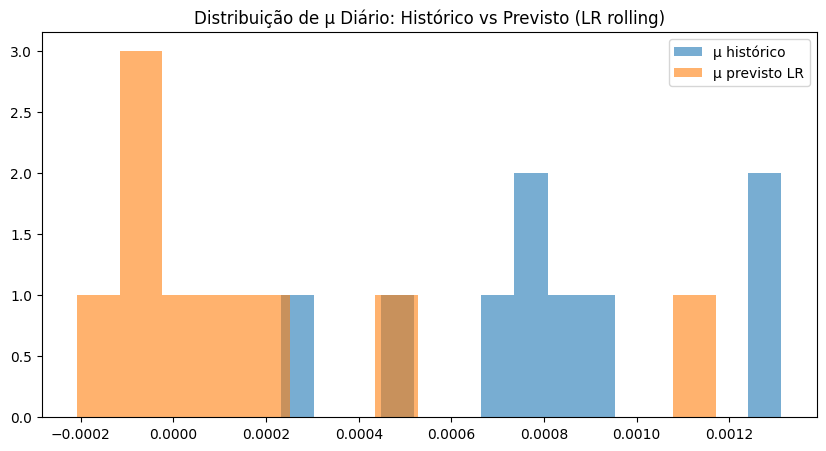

In [8]:
mu_daily_lr, mu_monthly_lr = expected_return_from_predictions(pred_daily_series)

print("Resumo das médias previstas (μ diário LR):")
display(mu_daily_lr.describe())

plt.figure(figsize=(10, 5))
plt.hist(mean_daily, bins=15, alpha=0.6, label="μ histórico")
plt.hist(mu_daily_lr, bins=15, alpha=0.6, label="μ previsto LR")
plt.title("Distribuição de μ Diário: Histórico vs Previsto (LR rolling)")
plt.legend()
plt.show()



In [9]:
lamb = 0.5
mean_returns_pred = mu_daily_lr

weights_pred = solve_markowitz(mean_returns_pred, cov_daily, lamb=lamb)

print("Pesos do portfólio (Markowitz + μ LR):")
display(pd.DataFrame({"Ticker": tickers, "Peso": weights_pred}).round(4))


Pesos do portfólio (Markowitz + μ LR):


,Ticker,Peso
0,PETR4.SA,0.3923
1,VALE3.SA,0.0000
2,ITUB4.SA,0.0000
3,BBDC4.SA,0.0000
4,BBAS3.SA,0.0000
5,ABEV3.SA,0.1918
6,WEGE3.SA,0.0000
7,B3SA3.SA,0.1977
8,GGBR4.SA,0.2182


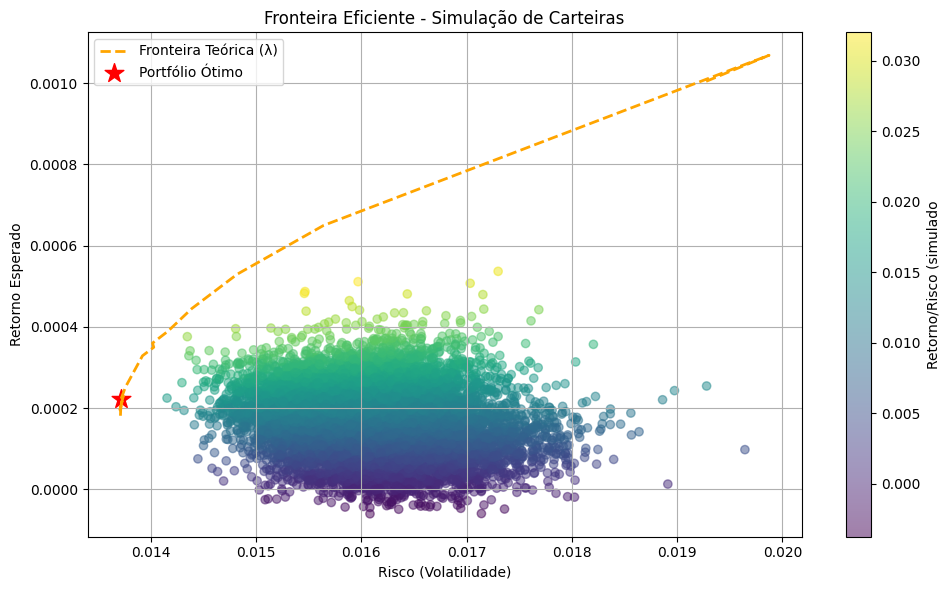

In [10]:
from outputs.charts.markowitz_plot import plot_efficient_frontier
plot_efficient_frontier(mean_returns_pred, cov_daily, optimized_weights=weights_pred)



In [11]:
results_lr = evaluate_portfolio(
    returns=returns_daily,
    weights=weights_pred,
    freq='daily',
    model_name="linear_metrics",
)

print("Métricas do Portfólio LR:")
display(pd.DataFrame([results_lr]))

pd.DataFrame([results_lr]).to_csv("../outputs/models/linear_metrics.csv", index=False)



Métricas do Portfólio LR:


,Model,Mean,Volatility,Sharpe,Cumulative_Return
0,linear_metrics,0.000675,0.013718,0.781387,2.368503


In [12]:
coefs = inspect_coefficients(prices, window=5)
print("Coeficientes (modelo inteiro):")
display(coefs.head(10))


Coeficientes (modelo inteiro):


,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,GGBR4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,WEGE3.SA
ABEV3.SA_lag1,-0.004840,-0.000821,-0.001864,-0.001529,-0.002325,-0.000662,-0.002900,-0.002769,-0.000292
ABEV3.SA_mean_5,0.009331,-0.000034,0.000411,0.000290,0.000589,-0.000364,0.000629,0.001386,0.000401
ABEV3.SA_std_5,0.000160,0.000027,-0.000415,-0.000565,-0.000097,-0.000425,0.000284,-0.000230,0.000378
B3SA3.SA_lag1,-0.000047,-0.006315,-0.000402,-0.000315,-0.000146,-0.000469,-0.000341,-0.000598,-0.000620
B3SA3.SA_mean_5,0.000007,0.013452,0.000753,0.000017,0.001755,0.000826,0.001632,0.001754,0.000876
B3SA3.SA_std_5,0.000492,-0.000208,0.000977,0.001184,-0.000111,0.000801,0.000135,-0.000041,-0.000512
BBAS3.SA_lag1,-0.000610,0.000437,-0.005426,-0.000192,0.000379,-0.000055,-0.000215,-0.000145,-0.001075
BBAS3.SA_mean_5,0.000028,-0.001647,0.011400,-0.000653,-0.000421,-0.000690,-0.000621,0.000417,-0.001449
BBAS3.SA_std_5,0.000496,-0.000509,0.000482,-0.000488,0.000064,0.000257,-0.000292,-0.000265,-0.000265
BBDC4.SA_lag1,-0.000845,0.000516,0.001621,-0.004777,0.000180,0.001174,0.001596,0.000409,-0.000534
